In [1]:
import numpy as np 
import pandas as pd

In [2]:
og_df = pd.read_csv('labels.csv')

In [3]:
og_df['label'].value_counts()

label
2    1426
3     930
1     708
Name: count, dtype: int64

In [4]:
import os

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split

In [6]:
df = og_df.copy()

In [7]:
df['label'] = df['label'] - df['label'].min()

In [8]:
# Image directory and resize config
img_dir = 'C:/Users/User/dimaag/png_images'
IMG_SIZE = (224, 224)

In [9]:
# Preload all images and labels into NumPy arrays
images = []
labels = []

for _, row in df.iterrows():
    img_path = os.path.join(img_dir, row['filename'])
    image = load_img(img_path, target_size=IMG_SIZE)
    image = img_to_array(image) / 255.0
    label = row['label']
    images.append(image)
    labels.append(label)

In [10]:
# Convert to NumPy arrays first
images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.int32)

In [11]:
#Now split the NumPy arrays
X_train, X_val, y_train, y_val = train_test_split(
    images, labels, test_size=0.2, stratify=labels, random_state=42
)

In [12]:
#Convert to TensorFlow tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_val   = tf.convert_to_tensor(X_val, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.int32)
y_val   = tf.convert_to_tensor(y_val, dtype=tf.int32)

In [13]:
df['label'].value_counts()

label
1    1426
2     930
0     708
Name: count, dtype: int64

PRETRAINED MODELS

1) MobileNetv2

In [16]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models
from tensorflow.keras import Sequential, Input

In [17]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(3, activation='softmax')  # 3 tumor classes
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # because labels are integers
    metrics=['accuracy']
)

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 37s 425ms/step - accuracy: 0.6572 - loss: 0.8204 - val_accuracy: 0.8483 - val_loss: 0.3988
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 416ms/step - accuracy: 0.8757 - loss: 0.3655 - val_accuracy: 0.8679 - val_loss: 0.3238
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 414ms/step - accuracy: 0.8961 - loss: 0.2955 - val_accuracy: 0.8777 - val_loss: 0.3056
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 416ms/step - accuracy: 0.9116 - loss: 0.2570 - val_accuracy: 0.8923 - val_loss: 0.3079
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 412ms/step - accuracy: 0.9132 - loss: 0.2438 - val_accuracy: 0.8923 - val_loss: 0.2643
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 419ms/step - accuracy: 0.9325 - loss: 0.2046 - val_accuracy: 0.8923 - val_loss: 0.2564
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 33s 428ms/step - accuracy: 0.9312 - loss: 0.2051 - val_accuracy: 0.9005 - val_loss: 0.2413
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 32s 418ms/step - accuracy: 0.9478 - loss: 0.1790 - val_accu

In [19]:
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = y_val.numpy() if isinstance(y_val, tf.Tensor) else y_val


20/20 ━━━━━━━━━━━━━━━━━━━━ 9s 358ms/step


In [20]:
print("\nClassification Report (MobileNetV2):")
class_names = ["Meningioma", "Glioma", "Pituitary"]
print(classification_report(y_true, y_pred, target_names=class_names))


Classification Report (MobileNetV2):
              precision    recall  f1-score   support

  Meningioma       0.79      0.87      0.83       142
      Glioma       0.96      0.89      0.92       285
   Pituitary       0.94      0.97      0.96       186

    accuracy                           0.91       613
   macro avg       0.90      0.91      0.90       613
weighted avg       0.91      0.91      0.91       613



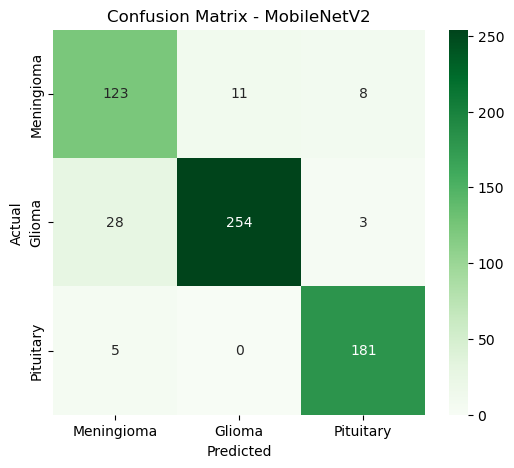

In [21]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()


In [22]:
print(f"MobileNetV2 Accuracy: {accuracy_score(y_true, y_pred):.4f}")

MobileNetV2 Accuracy: 0.9103
